# Working with ORAS5 data 

Creating an alternative climatology from this longer time series to be used with our OSNAP data

In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
import xarray as xr
import cmocean as cm
import marineHeatWaves as mhw
from datetime import date
import pandas as pd
from scipy import signal

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#font = {'weight' : 'normal','size' : 10}
#plt.rc('font', **font)

# Import Data

In [4]:
file_name = "data/ORAS5.nc"
oras5 = xr.open_dataset(file_name)
oras5=oras5.rename({'depth':'DEPTH','time':'TIME'})

In [5]:
#depth_E = [50, 75, 100, 250, 500, 750, 950, 1000, 1250, 1500, 1600, 1750] 
#depth_W = [50, 75, 100, 250, 500, 750, 1000, 1250, 1500, 1600, 1750]

In [6]:
# all years
oras5_EB = oras5.thetao_oras.sel(latitude = 57.1, longitude = -9.6, method = 'nearest')
oras5_WB = oras5.thetao_oras.sel(latitude = 57.5, longitude = -12.5, method = 'nearest')

In [7]:
# 10 years
oras5_EB_10 = oras5_EB.sel(TIME=slice('2014-01-01', '2019-12-31'))
oras5_WB_10 = oras5_WB.sel(TIME=slice('2014-01-01', '2019-12-31'))

In [11]:
# detrend -› cannot deal with NaNs
#signal.detrend(oras5_EB)

In [12]:
oras5_EB_10

<xarray.DataArray 'thetao_oras' (TIME: 2191, DEPTH: 54)>
[118314 values with dtype=float32]
Coordinates:
  * DEPTH      (DEPTH) float32 0.5058 1.556 2.668 ... 1.796e+03 1.945e+03
    latitude   float32 57.0
  * TIME       (TIME) datetime64[ns] 2014-01-01 2014-01-02 ... 2019-12-31
    longitude  float32 -9.5
Attributes:
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    units:          degrees_C
    unit_long:      Degrees Celsius
    cell_methods:   area: mean
    _ChunkSizes:    [  1  15 137 288]

In [13]:
oras5_WB

<xarray.DataArray 'thetao_oras' (TIME: 9861, DEPTH: 54)>
[532494 values with dtype=float32]
Coordinates:
  * DEPTH      (DEPTH) float32 0.5058 1.556 2.668 ... 1.796e+03 1.945e+03
    latitude   float32 57.5
  * TIME       (TIME) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-31
    longitude  float32 -12.5
Attributes:
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    units:          degrees_C
    unit_long:      Degrees Celsius
    cell_methods:   area: mean
    _ChunkSizes:    [  1  15 137 288]

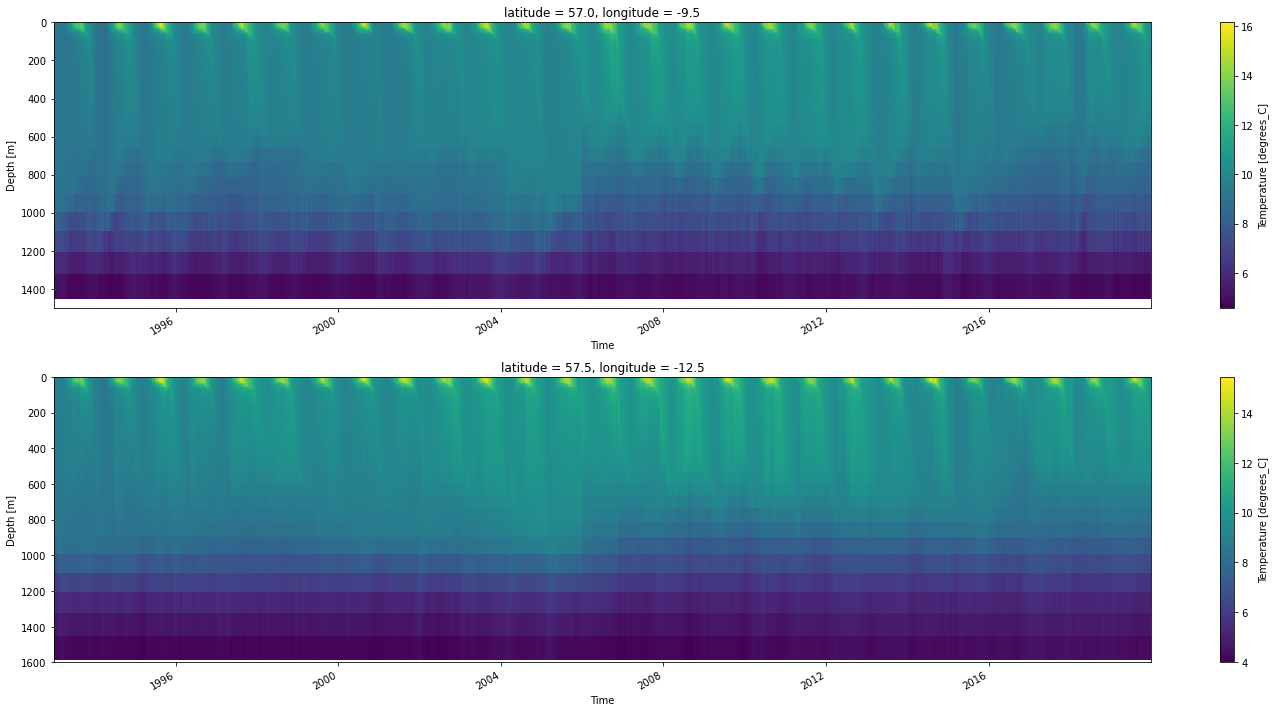

In [14]:
fig, ax = plt.subplots(2,1, figsize = (20, 10))
oras5_EB.plot(x='TIME', y='DEPTH', yincrease = False, ax = ax[0])
ax[0].set_ylim(1500,0)
oras5_WB.plot(x='TIME', y='DEPTH', yincrease = False,ax = ax[1])
ax[1].set_ylim(1600,0)
fig.tight_layout();

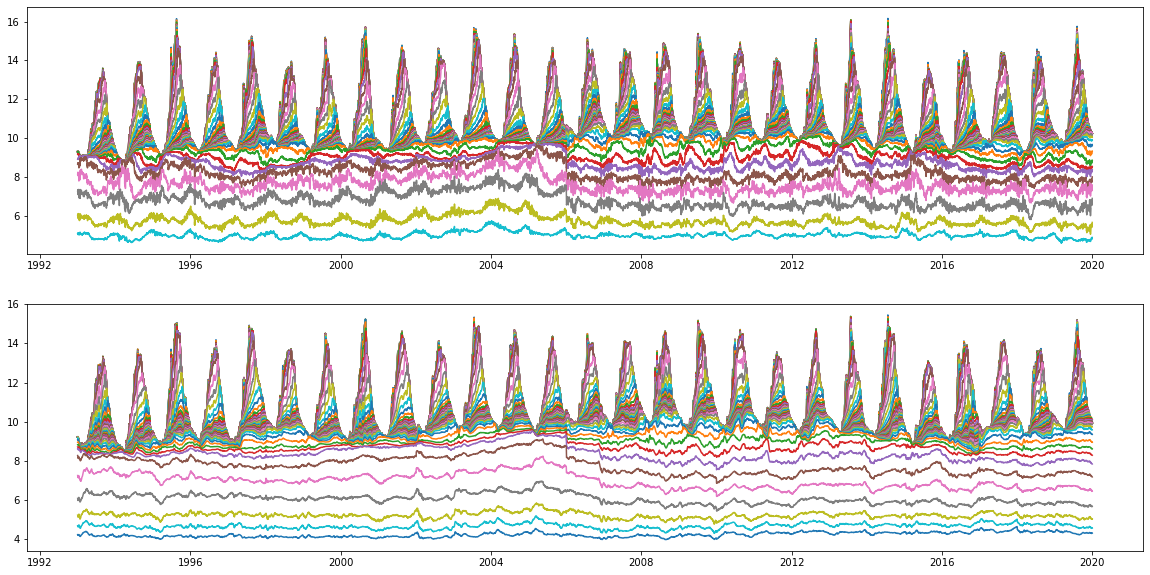

In [15]:
fig, ax = plt.subplots(2,1, figsize = (20,10))
ax[0].plot(oras5_EB.TIME, oras5_EB)
ax[1].plot(oras5_WB.TIME, oras5_WB);

# Functions

In [16]:
def MHW_func (data, depth, climP=[1993.0,2019.0], altClim=False):
    yy_start = int(data.TIME[0].dt.year)
    yy_end = int(data.TIME[-1].dt.year)
    mm_start = int(data.TIME[0].dt.month)
    mm_end = int(data.TIME[-1].dt.month)
    dd_start = int(data.TIME[0].dt.day)
    dd_end = int(data.TIME[-1].dt.day)
    
    t = np.arange(
        date(yy_start, mm_start, dd_start).toordinal(),                 
        date(yy_end, mm_end, dd_end).toordinal()+1,1) 
    
    temp = data.sel(DEPTH=depth, method = 'nearest').squeeze().values   
    
    mhws, clim = mhw.detect(t, temp, climatologyPeriod=climP, alternateClimatology=altClim)     
    mcss, clim_cold = mhw.detect(t, temp, coldSpells = True, climatologyPeriod=climP, alternateClimatology=altClim)     
    return mhws, mcss, clim, clim_cold, t, temp  

In [17]:
def DICT_func(data, depth, climP=[1993.0,2019.0], altClim=False):  
    mhws_,mcss_,clim_,clim_cold_,t_,temp_ = {},{},{},{},{},{}

    for n in depth:
            
        mhws, mcss, clim, clim_cold, t, temp = MHW_func(data, n, climP, altClim)
        mhws_.update({str(n):mhws})
        mcss_.update({str(n):mcss})
        clim_.update({str(n):clim})
        clim_cold_.update({str(n):clim_cold})
        t_.update({str(n):t})
        temp_.update({str(n):temp})
    
    dictionary = {'mhws':mhws_,'mcss':mcss_,'clim':clim_,'clim_cold':clim_cold_,'t':t_,'temp':temp_}
    return dictionary

In [18]:
def ALL_events(dict, n):
    
    #defining my variables
    mhws = dict['mhws'][str(n)]
    mcss = dict['mcss'][str(n)]
    t = dict['t'][str(n)]
    temp = dict['temp'][str(n)]
    clim = dict['clim'][str(n)]
    clim_cold = dict['clim_cold'][str(n)]
    
    dates = [date.fromordinal(tt.astype(int)) for tt in t]

    ev = (mhws['n_events'])
    ec = (mcss['n_events'])

    plt.figure(figsize=(30,15))
    plt.subplot(2,1,1)
    
    plt.rc('font', size=20) #controls default text size
    plt.rc('axes', titlesize=25) #fontsize of the title
    plt.rc('legend', fontsize=14) #fontsize of the legend

    # Plot t, seasonal cycle, and threshold
    plt.plot(dates, clim['thresh'], ':r', label = 'Threshold warm')
    plt.plot(dates, clim_cold['thresh'], ':g', label = 'Threshold cold')
    plt.plot(dates, temp, 'k', label = 'Temperature', linewidth = .75)
    plt.plot(dates, clim['seas'], 'b', label = 'Climatology')
    plt.legend()
    plt.title(f'Data Overview {n}')
    plt.xlim(dates[0], dates[-1])
    #plt.xlim(date(2016,1,1), date(2017,5,1))
    plt.ylim(temp.min()-0.1, temp.max()+0.1)
    plt.ylabel(r't $^\circ$C')
    plt.grid()
 
    # plt the heatwaves
    plt.subplot(2,1,2)

    # Find all MHWs and shade
    for ev0 in np.arange (ev):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]
        plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], \
                         color='pink')

    # Find MHW of interest and shade accordingly
    ev_i = np.argmax(mhws['intensity_max'])
    t1 = np.where(t==mhws['time_start'][ev_i])[0][0]
    t2 = np.where(t==mhws['time_end'][ev_i])[0][0]
    plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color='deeppink', label = 'MHW event with max intensity')


    # same for cold spells
    for ec0 in np.arange(ec):
        tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
        tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
        plt.fill_between(dates[tc1:tc2+1], temp[tc1:tc2+1], clim_cold['thresh'][tc1:tc2+1], \
                         color='cyan')

    # Find MCSS of interest and shade accordingly
    ec_i = np.argmin(mcss['intensity_max'])
    tc1 = np.where(t==mcss['time_start'][ec_i])[0][0]
    tc2 = np.where(t==mcss['time_end'][ec_i])[0][0]
    plt.fill_between(dates[tc1:tc2+1], temp[tc1:tc2+1], clim_cold['thresh'][tc1:tc2+1], \
                     color='darkcyan', label = 'MCSS event with max intensity')    

    # Plot t, seasonal cycle, threshold, shade MHWs with main event in red
    plt.plot(dates, clim['thresh'], ':r', linewidth=2, label = 'Threshold warm')
    plt.plot(dates, clim_cold['thresh'], ':g', linewidth=2, label = 'Threshold cold')
    plt.plot(dates, temp, 'k', linewidth=.75, label = 'Temperature')
    plt.plot(dates, clim['seas'], 'b', linewidth=2, label = 'Climatology')
    plt.legend()
    plt.title(f'Marine Heatwaves and Cold Spells {n}')
    #plt.xlim(date(2016,6,1), date(2018,6,1))
    #plt.xlim(dates[0], dates[-1])
    #plt.xlim(mhws['date_start'][ev-12], mhws['date_end'][ev+4])
    plt.ylim(temp.min()-0.1, temp.max()+0.1)
    plt.grid()
    plt.ylabel(r't $^\circ$C');

    
    #print some intersting stats
    print('Overview:')
    print('Number of MHWs: ', ev)
    print('Number of MCSs: ', ec)
    print('The MHWs of max intensity lastet from the', mhws['date_start'][ev_i], 'to the', mhws['date_end'][ev_i])
    print('The MCSs of max intensity lastet from the', mcss['date_start'][ec_i], 'to the', mcss['date_end'][ec_i])
    print(' ')

In [40]:
def OV_stacked_events(dict, depth, w, h, title='bla', save=False):
    
    fig, ax = plt.subplots(len(depth),1, figsize=(w,h), sharex=True)
    fig.subplots_adjust(hspace=0)
    fig.tight_layout()
    
    for i,n in enumerate(depth):
        mhws = dict['mhws'][str(n)]
        mcss = dict['mcss'][str(n)]
        t = dict['t'][str(n)]
        temp = dict['temp'][str(n)]
        clim = dict['clim'][str(n)]
        clim_cold = dict['clim_cold'][str(n)]

        dates = [date.fromordinal(tt.astype(int)) for tt in t]

        ev = (mhws['n_events'])
        ec = (mcss['n_events'])

        # Find all MHWs and shade
        for ev0 in np.arange (ev):
            t1 = np.where(t==mhws['time_start'][ev0])[0][0]
            t2 = np.where(t==mhws['time_end'][ev0])[0][0]   
            ax[i].axvspan(xmin=dates[t1], xmax=dates[t2],color='deeppink', label= 'MHWs')

        # same for cold spells
        for ec0 in np.arange(ec):
            tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
            tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
            ax[i].axvspan(xmin=dates[tc1], xmax=dates[tc2],color='darkcyan', label = 'MCSs')

        #ax[num].set_xlim(date(2014,7,15), date(2020,10,20))
        ax[i].grid(axis = 'x')
        ax[i].set_ylabel(str(n),rotation=0, labelpad=20)
        ax[0].set_title(title)
        

        ax[i].tick_params(axis='y', which='both', right=False,
                    left=False, labelleft=False);
    if save:
        fig.savefig(f'figures/Stats/{title}', dpi = 300)
    

# Dictionary

In [21]:
# all depth
depth = np.array(oras5_EB.DEPTH).astype(int)
depth_short = np.array(oras5_EB.DEPTH.isel(DEPTH=slice(0,50))).astype(int)

In [22]:
# all years
ora_EB = DICT_func(oras5_EB, depth)
ora_WB = DICT_func(oras5_WB, depth)

In [23]:
# all years 10 year clim
ora_EB_clim = DICT_func(oras5_EB, depth, climP=[2014.0, 2019.0])
ora_WB_clim = DICT_func(oras5_WB, depth, climP=[2014.0, 2019.0])

In [24]:
oras5_EB

<xarray.DataArray 'thetao_oras' (TIME: 9861, DEPTH: 54)>
array([[ 9.301797,  9.3018  ,  9.301804, ...,       nan,       nan,       nan],
       [ 9.301973,  9.301975,  9.301978, ...,       nan,       nan,       nan],
       [ 9.29812 ,  9.298241,  9.298355, ...,       nan,       nan,       nan],
       ...,
       [10.277826, 10.277831, 10.277837, ...,       nan,       nan,       nan],
       [10.25963 , 10.259807, 10.259933, ...,       nan,       nan,       nan],
       [10.239496, 10.239502, 10.239507, ...,       nan,       nan,       nan]],
      dtype=float32)
Coordinates:
  * DEPTH      (DEPTH) float32 0.5058 1.556 2.668 ... 1.796e+03 1.945e+03
    latitude   float32 57.0
  * TIME       (TIME) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-31
    longitude  float32 -9.5
Attributes:
    long_name:      Temperature
    standard_name:  sea_water_potential_temperature
    units:          degrees_C
    unit_long:      Degrees Celsius
    cell_methods:   area: mean
    _ChunkSizes:    [  1  15 137 288]

In [26]:
# all years
ora_EB_10 = DICT_func(oras5_EB_10, depth, climP=[2014.0, 2019.0])
ora_WB_10 = DICT_func(oras5_WB_10, depth, climP=[2014.0, 2019.0])

# Plots EB

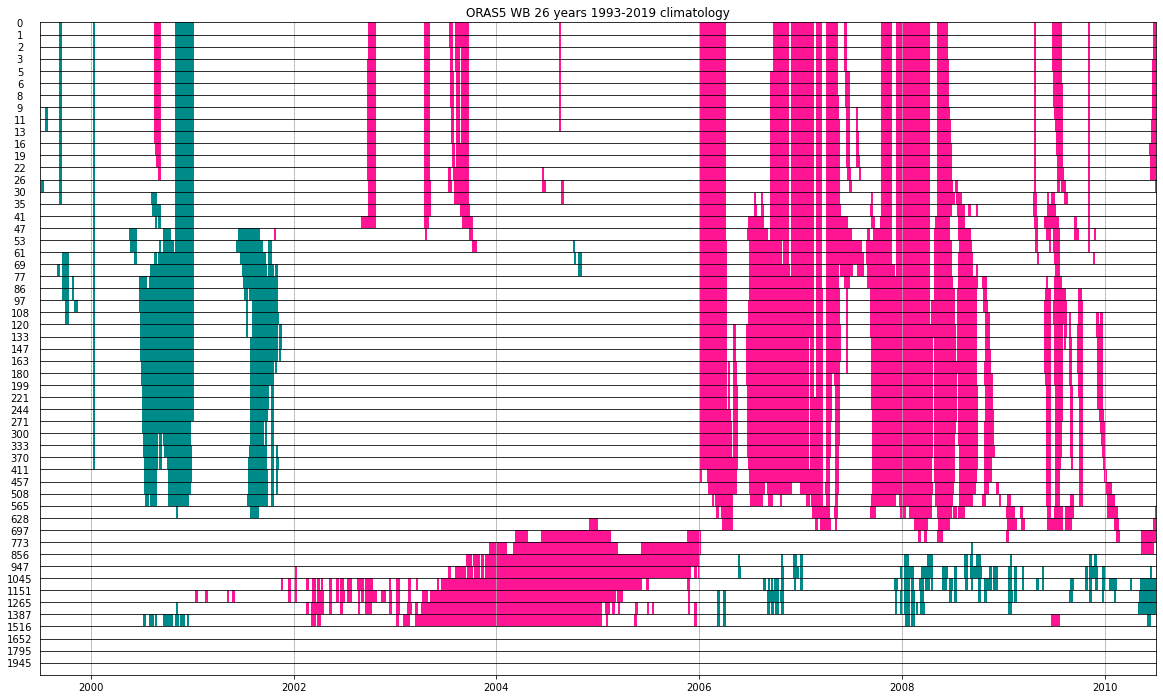

In [32]:
a = False
OV_stacked_events(ora_EB, depth, 20, 12, 'ORAS5 WB 26 years 1993-2019 climatology', save=a)
OV_stacked_events(ora_EB_clim, depth, 20, 12, 'ORAS5 EB 26 years 2010-2019 climatology', save=a)
OV_stacked_events(ora_EB_10, depth_short, 20, 12, 'ORAS5 EB 10 years 2010-2019 climatology', save=a)

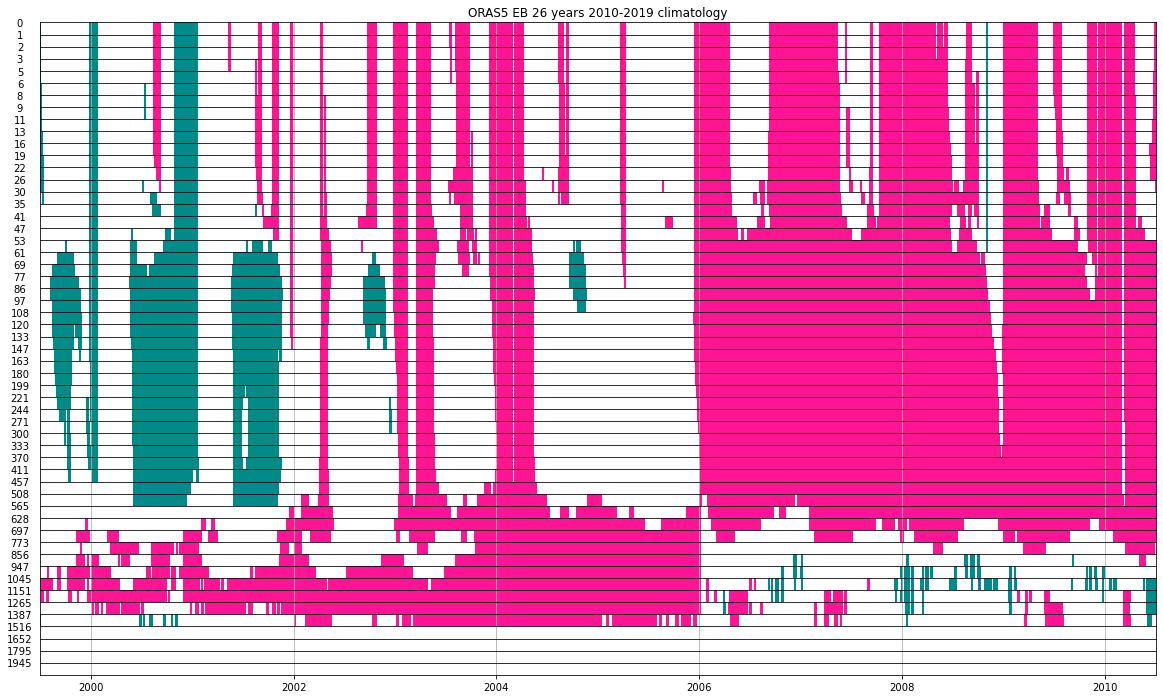

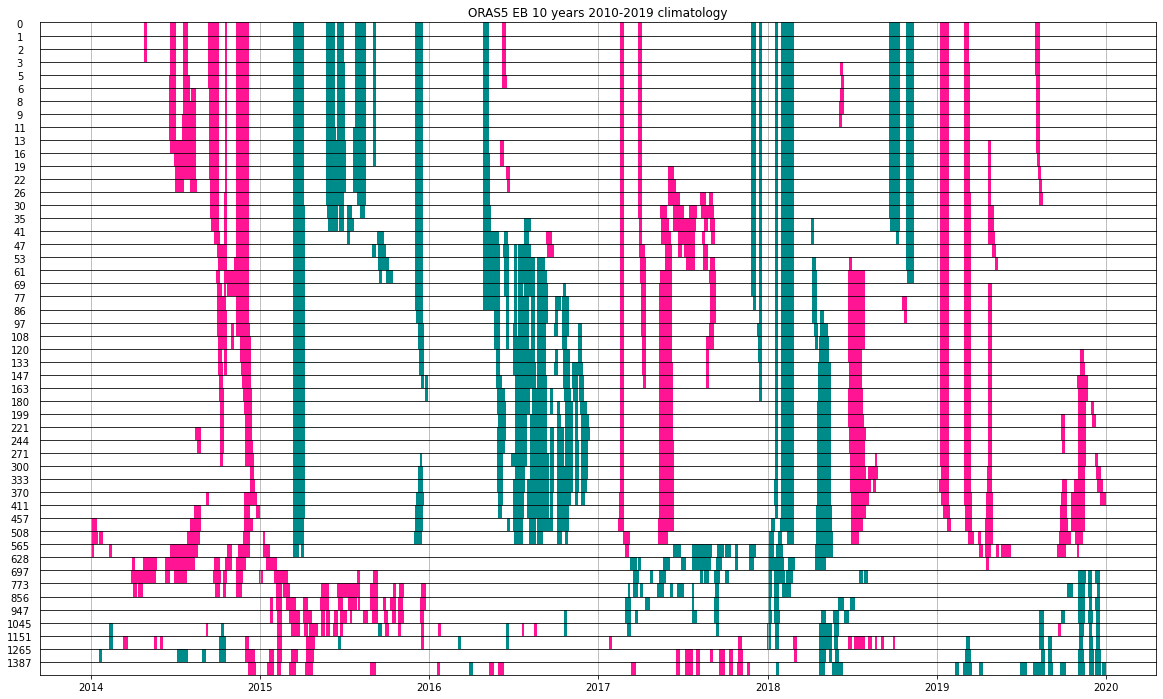

# Plots WB

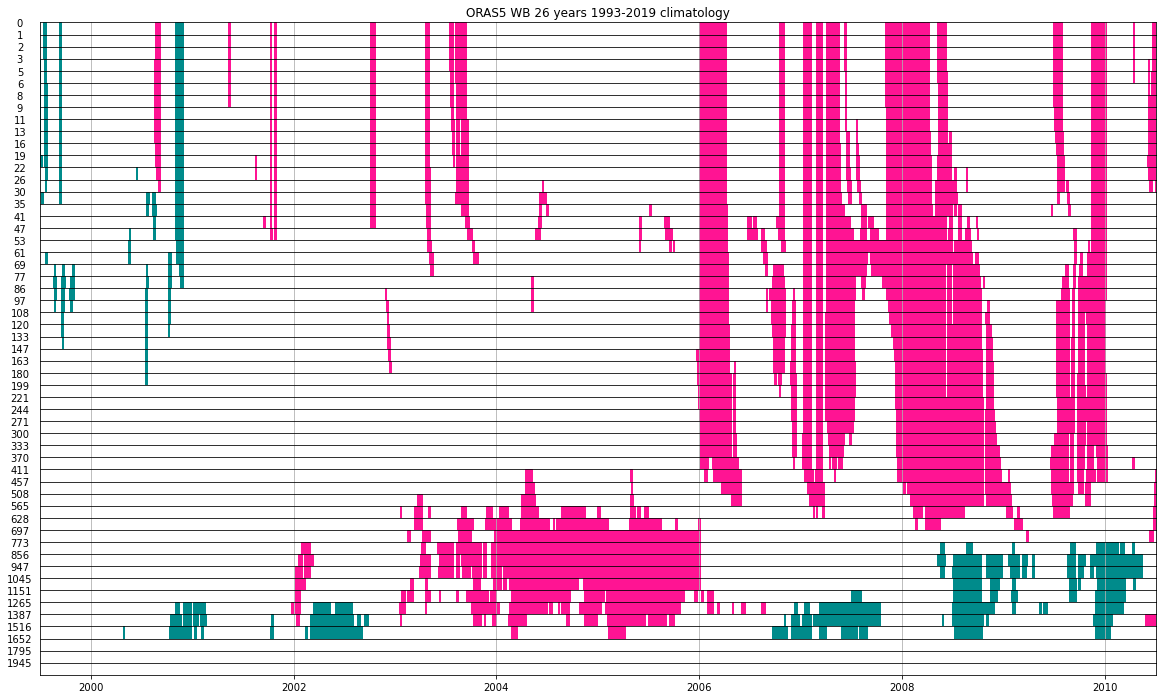

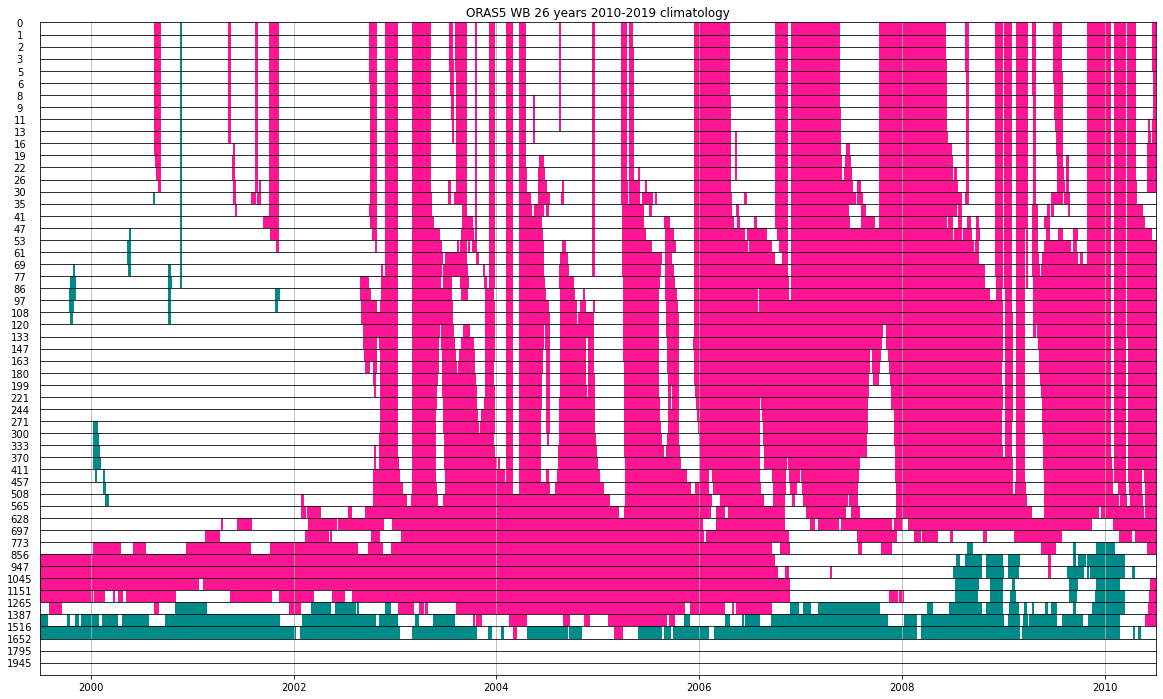

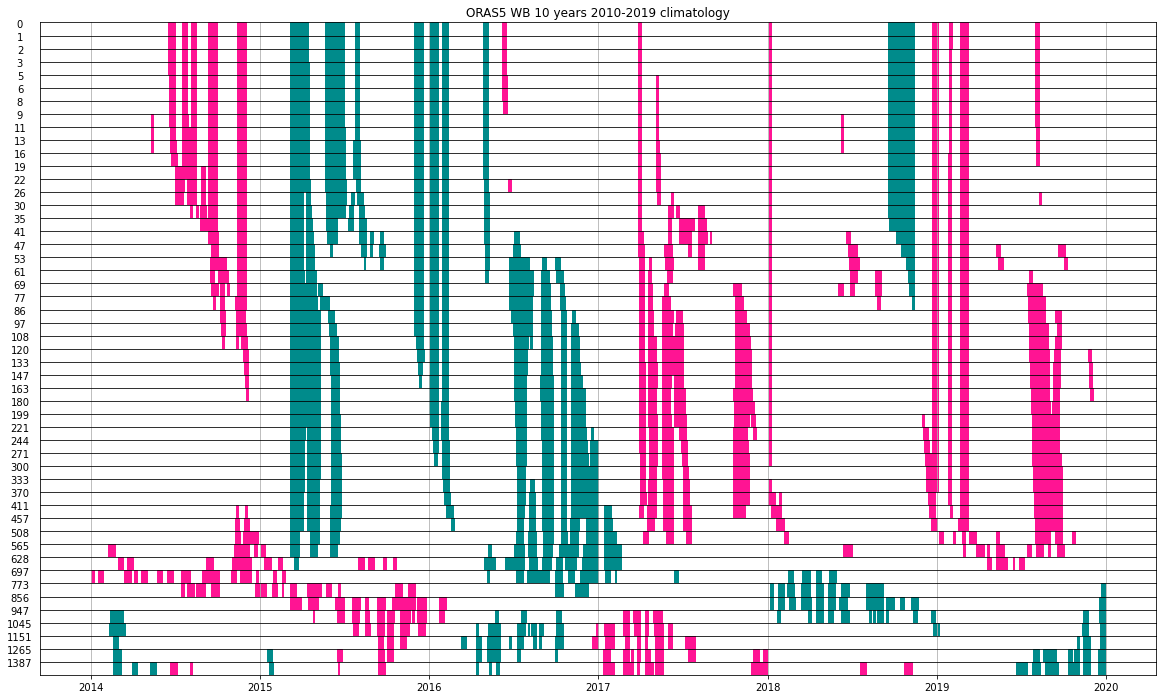

In [39]:
a = False
OV_stacked_events(ora_WB, depth, 20, 12, 'ORAS5 WB 26 years 1993-2019 climatology', save=a)   
OV_stacked_events(ora_WB_clim, depth, 20, 12, 'ORAS5 WB 26 years 2010-2019 climatology', save=a)
OV_stacked_events(ora_WB_10, depth_short, 20, 12, 'ORAS5 WB 10 years 2010-2019 climatology', save=a)